In [29]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
from warnings import filterwarnings
filterwarnings('ignore')

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.12.0


### Just playing around with tensorflow.  I don't believe there are enough observations here to warrant a deep neural net.

In [30]:
data = pd.read_csv('../notebooks/data/merged_inputed_data.csv')

data.shape

(1305, 358)

In [31]:
data = data[[col for col in data.columns if col.startswith('test') and 'Opiate300' in col]+['medication','responder']]

data

,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,test_Opiate300_5,test_Opiate300_6,test_Opiate300_7,test_Opiate300_8,test_Opiate300_9,...,test_Opiate300_17,test_Opiate300_18,test_Opiate300_19,test_Opiate300_20,test_Opiate300_21,test_Opiate300_22,test_Opiate300_23,test_Opiate300_24,medication,responder
0,1.0,0.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1301,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0
1302,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0
1303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [32]:
train_dataset = data.sample(frac=0.75, random_state=1)

len(train_dataset)


979

In [33]:

test_dataset = data.drop(train_dataset.index)

len(test_dataset)

# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:,:-1], train_dataset.iloc[:, -1]
x_test, y_test = test_dataset.iloc[:, :-1], test_dataset.iloc[:, -1]

In [34]:
# convert to tensors
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [35]:
# show the index for the columns in the train_dataset
train_dataset.iloc[:,0:26]

,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,test_Opiate300_5,test_Opiate300_6,test_Opiate300_7,test_Opiate300_8,test_Opiate300_9,...,test_Opiate300_16,test_Opiate300_17,test_Opiate300_18,test_Opiate300_19,test_Opiate300_20,test_Opiate300_21,test_Opiate300_22,test_Opiate300_23,test_Opiate300_24,medication
644,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1032,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
163,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
909,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-5.0,-5.0,-5.0,1.0,1.0,1.0,1.0,1.0,2.0
1219,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
518,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
918,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [36]:
# sns.pairplot(train_dataset.iloc[:, 0:26], hue = 'medication', diag_kind='kde');
# There are too many columns for the pair plot to work

In [37]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

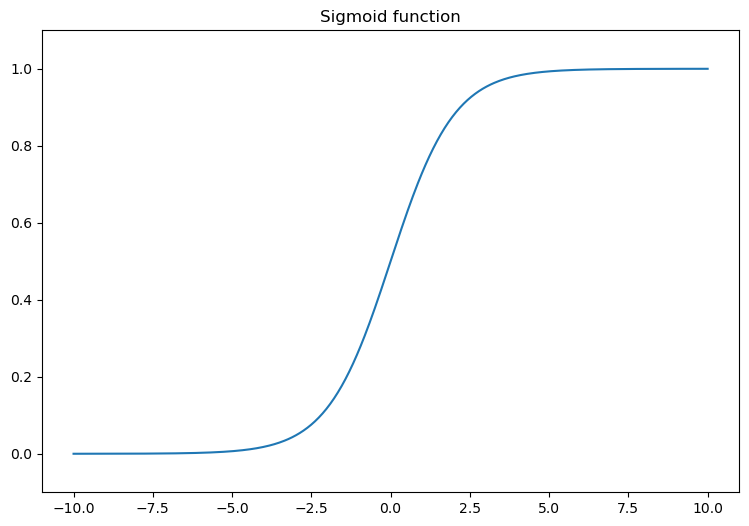

In [38]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [39]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [40]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [41]:
log_reg = LogisticRegression()

In [42]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([9.9982464e-01, 9.9977255e-01, 9.9982464e-01, 3.1771290e-04,
       1.3127157e-01], dtype=float32)

In [43]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [44]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [45]:
# Set training parameters
epochs = 400
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

2024-03-21 21:50:23.650307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [979]
	 [[{{node Placeholder/_1}}]]
2024-03-21 21:50:23.724755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [326,26]
	 [[{{node Placeholder/_0}}]]


Epoch: 0, Training log loss: 4.835
Epoch: 20, Training log loss: 0.459
Epoch: 40, Training log loss: 0.373
Epoch: 60, Training log loss: 0.300
Epoch: 80, Training log loss: 0.274
Epoch: 100, Training log loss: 0.259
Epoch: 120, Training log loss: 0.248
Epoch: 140, Training log loss: 0.243
Epoch: 160, Training log loss: 0.246
Epoch: 180, Training log loss: 0.239
Epoch: 200, Training log loss: 0.241
Epoch: 220, Training log loss: 0.228
Epoch: 240, Training log loss: 0.243
Epoch: 260, Training log loss: 0.230
Epoch: 280, Training log loss: 0.225
Epoch: 300, Training log loss: 0.226
Epoch: 320, Training log loss: 0.232
Epoch: 340, Training log loss: 0.236
Epoch: 360, Training log loss: 0.233
Epoch: 380, Training log loss: 0.223


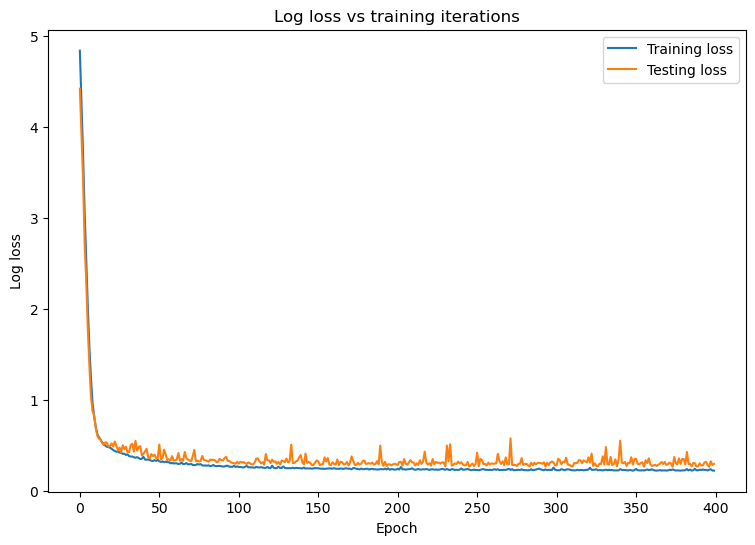

In [58]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

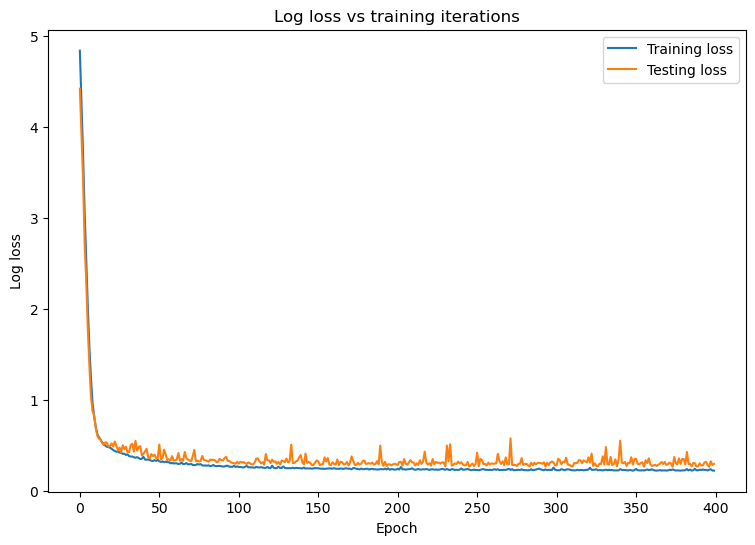

In [59]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

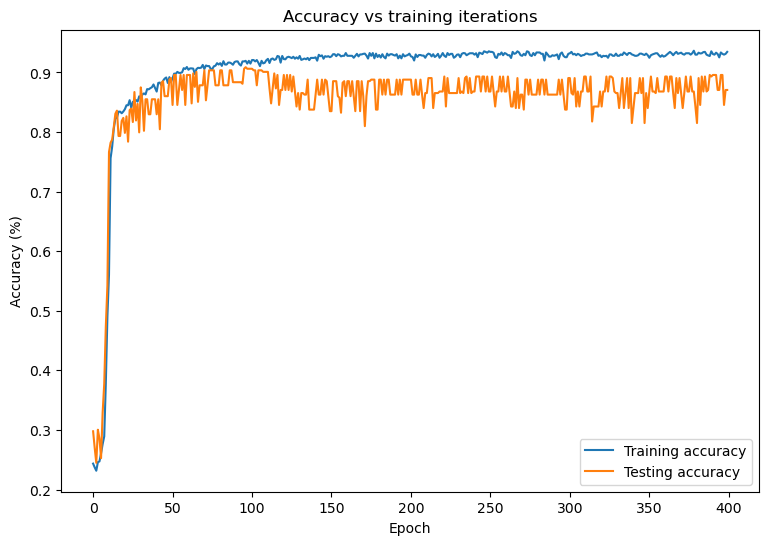

In [60]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [61]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.220
Final testing log Loss: 0.294


In [62]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.935
Final testing accuracy: 0.871


In [63]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

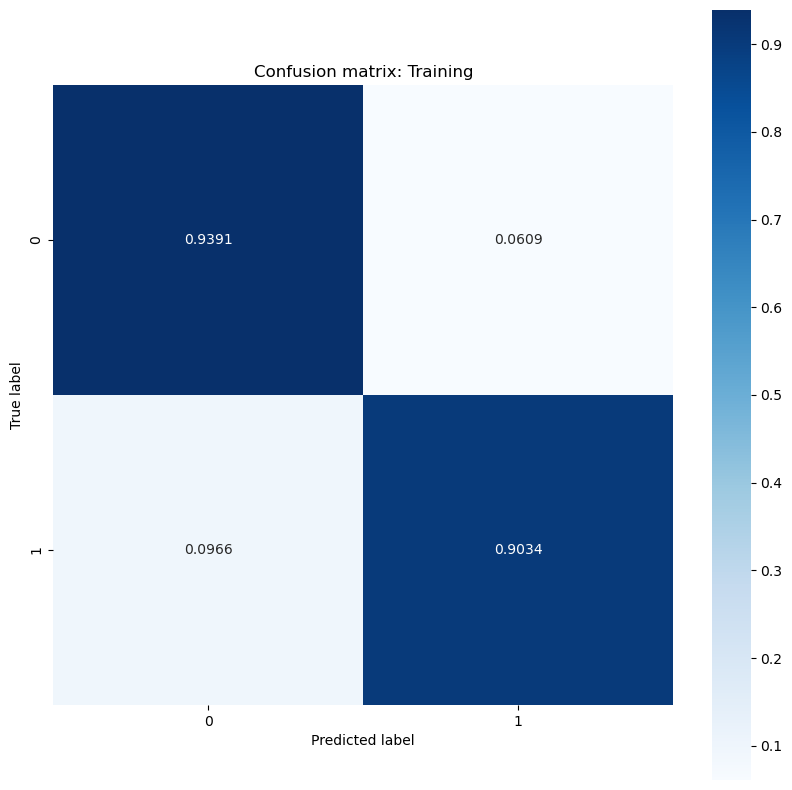

In [64]:
show_confusion_matrix(y_train, train_classes, 'Training')

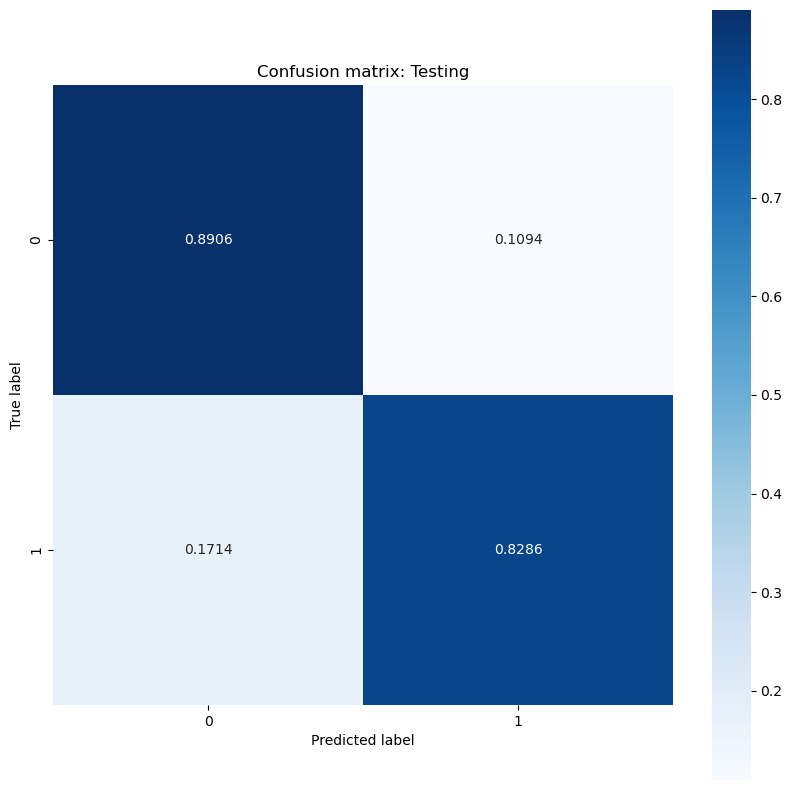

In [65]:
show_confusion_matrix(y_test, test_classes, 'Testing')

In [54]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [55]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

In [56]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

INFO:tensorflow:Assets written to: /var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/tmpxkdfz4yt/log_reg_export/assets


In [57]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([1., 1., 1., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)